In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd
import datetime as dt
from datetime import date, timedelta, datetime

## Reflect Tables into SQLALchemy ORM

In [3]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect

In [4]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [5]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect = True)

In [6]:
# View all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [7]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [8]:
# Create our session (link) from Python to the DB
session = Session(engine)

## Bonus Challenge Assignment: Temperature Analysis II

In [9]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, maximum, and average temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# For example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [10]:
# Use the function `calc_temps` to calculate the tmin, tavg, and tmax 
# for a year in the data set
temp_calcs = calc_temps('2011-01-01','2011-12-31')[0]
print(f" Min: {temp_calcs[0]}°F\nMean: {round(temp_calcs[1],2)}°F\n Max: {temp_calcs[2]}°F")

 Min: 56.0°F
Mean: 72.67°F
 Max: 86.0°F


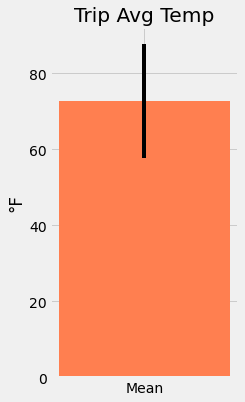

In [11]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for bar height (y value)
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)
plt.figure(figsize=(3,6))
plt.bar(['Mean'], temp_calcs[1], yerr=(temp_calcs[2]-temp_calcs[0])/2, color='coral')
plt.title('Trip Avg Temp')
plt.ylabel('°F')
plt.show()

### Daily Rainfall Average

In [12]:
# Measurement columns
inspector = inspect(engine)
columns = inspector.get_columns('measurement')
for c in columns:
    print(f"{c['name']:<20} {c['type']}")

id                   INTEGER
station              TEXT
date                 TEXT
prcp                 FLOAT
tobs                 FLOAT


In [13]:
def convert_str_to_date(string_date):
    # split string to break out year, mo, day
    nd = string_date.split('-')
    #print(f"list of strings: {nd}")
    # cast strings as int
    for i in range(len(nd)):
        nd[i] = int(nd[i])
    #print(f"list of ints: {nd}")
    # store as datetime object
    nd_dt = dt.date(nd[0], nd[1], nd[2])
    return nd_dt

In [14]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's 
# matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation

# Find start and end dates for above query:
sel = [Measurement.date]
newest_date = session.query(*sel).order_by(Measurement.date.desc()).first()[0]
newest_date
nd_dt = convert_str_to_date(newest_date)
# output: datetime.date(2017, 8, 23)
one_year_previous = nd_dt - dt.timedelta(days=365)
one_year_previous
# output: datetime.date(2016, 8, 23)

# Trip start / end dates are shown in below cell.  These are one year prior to that date range:
last_year_rain_start = '2016-08-01'
last_year_rain_end = '2016-08-07'

sel = [Measurement.prcp]
rain_list = session.query(*sel).filter(Measurement.date >= last_year_rain_start).\
    filter(Measurement.date <= last_year_rain_end).all()

# Pull values out of tuples in list
rain_list = [r for (r,) in rain_list]

# Remove None values from list
rain_list = list(filter(None, rain_list))
rain_list

total_rain = sum(rain_list)
total_rain
# output: 17.34

station_count = engine.execute('SELECT COUNT(station) FROM station').fetchall()[0][0]
station_count
# output: 9

# calculate rain per station
avg_rain_per_station = round((total_rain / station_count), 2)
print(f"Average rain per weather measurement station: {avg_rain_per_station} inches.")

Average rain per weather measurement station: 1.93 inches.


### Daily Temperature Normals

In [15]:
# Use this function to calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()

# For example
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [16]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip
start_date = '2017-08-01'
end_date = '2017-08-07'

sdate = convert_str_to_date(start_date)
edate = convert_str_to_date(end_date)
delta = edate-sdate

# Use the start and end date to create a range of dates
dates = []
for i in range(delta.days + 1):
    day = sdate + timedelta(days=i)
    dates.append(day)
dates
# [datetime.date(2017, 8, 1),
#  datetime.date(2017, 8, 2),

# Strip off the year and save a list of strings in the format %m-%d
date_list = []
for day in dates:
    #date_list.append(f"{day.month}-{day.day}")
    date_list.append(datetime.strftime(day, "%m-%d"))
date_list
# ['08-01', '08-02', '08-03', '08-04', '08-05', '08-06', '08-07']

# Use the `daily_normals` function to calculate the normals for each date string 
# and append the results to a list called `normals`.
normals = []
for day in date_list:
    normals.append(daily_normals(day))
normals
normals_fmt = []
for i in range(len(normals)):
    for j in normals[i]:
        normals_fmt.append(j)
normals_fmt

[(67.0, 75.54, 83.0),
 (68.0, 75.60377358490567, 84.0),
 (70.0, 76.61111111111111, 85.0),
 (69.0, 76.71153846153847, 84.0),
 (69.0, 76.14814814814815, 82.0),
 (67.0, 76.25, 83.0),
 (71.0, 77.15686274509804, 83.0)]

In [17]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index
normals_df = pd.DataFrame(normals_fmt, columns = ['tmin','tavg','tmax'])
normals_df['trip_dates'] = date_list
normals_df.set_index('trip_dates', inplace=True)
normals_df

,tmin,tavg,tmax
trip_dates,,,
08-01,67.0,75.540000,83.0
08-02,68.0,75.603774,84.0
08-03,70.0,76.611111,85.0
08-04,69.0,76.711538,84.0
08-05,69.0,76.148148,82.0
08-06,67.0,76.250000,83.0
08-07,71.0,77.156863,83.0


<AxesSubplot:xlabel='trip_dates'>

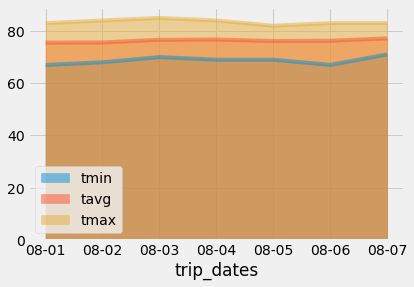

In [18]:
# Plot the daily normals as an area plot with `stacked=False`
normals_df.plot.area(stacked=False)

## Close Session

In [19]:
session.close()
